# Short term plasticity model parameter estimation

In [1]:
%matplotlib inline

import numpy as np
import csv
import matplotlib.pyplot as plt
import pymc as pm
import scipy.stats as stats
from scipy.interpolate import interp1d

In [103]:
def remove_upper_right_ticks(ax):
    '''Remove and lines from upper and right edges of figure'''
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

def load_amps_irr_csv(path):
    '''Load PSC amplitudes and intervals between them'''
    with open(path+'.csv','rb') as myfile:
        rd = csv.reader(myfile)
        data = [row for row in rd]
        amps = np.array([eval(d) for d in data[0]])
        ivls = np.squeeze([eval(l) for l in data[1]])
    return amps,ivls

amps,ivls = load_amps_irr_csv('./fig3_data/cch_epsc1')

In [4]:
'''Use one sample to show how parameter estimation works'''
amps = np.array(amps[0])
    
'''Prior distributions over parameters in facilitation only model'''
tauf = pm.Uniform('tauf',0.1,40)
g = pm.Exponential('g',beta=1./5.)
f0 = pm.Beta('f0',alpha=2,beta=10)
a = pm.Beta('a',alpha=2,beta=10)

'''Short term facilitation model'''
def fac_prob(g=g,f0=f0,tauf=tauf,a=a,ivls=ivls):
    amps=[]
    f = f0
    amps.append(g*f)
    for ivl in ivls:
        f_old = f
        finc = f_old + a*(1-f_old)
        f_new = f0 - (f0 -finc)*np.exp(-ivl/tauf)
        f = f_new
        amps.append(g*f)
    return np.array(amps)

'''STP model used to give parameters for normal distribution'''
@pm.deterministic
def mu_amps(g=g,f0=f0,tauf=tauf,a=a):
    out = fac_prob(g=g,f0=f0,tauf=tauf,a=a)
    return out

@pm.deterministic
def tau_amps(g=g,f0=f0,tauf=tauf,a=a):
    amps = fac_prob(g=g,f0=f0,tauf=tauf,a=a)
    var_amps = np.clip(0.5*amps,0,np.inf)
    out = np.diag(1.0/var_amps)
    return out
    
'''
Observed amplitudes modelled as realisations of a multivariate normal distribution
with no covariance. Couldn't find a simpler way to do this with pymc
'''
obs = pm.MvNormal("obs",mu_amps,tau_amps,value=amps,observed=True)
'''Model description'''
model = pm.Model([obs,mu_amps,tau_amps,tauf,g,f0,a])
'''Start MCMC from peaks of priors'''
map_ = pm.MAP(model).fit()
'''Number of samples drawn in random walk'''
n_samples = 50000
'''Run MCMC- metropolis hastings'''
mcmc = pm.MCMC(model)
mcmc.sample(n_samples,burn=10000,thin=10)
mcmc.db.close()

/home/luke/anaconda2/envs/data/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in double_scalars
/home/luke/anaconda2/envs/data/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


 [-----------------100%-----------------] 50000 of 50000 complete in 228.8 sec

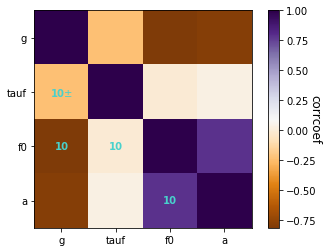

In [161]:
from itertools import combinations

# plt.plot(mcmc.trace('tauf')[:], mcmc.trace('f0')[:], 'o')

plt.imshow(np.corrcoef([mcmc.trace('g')[:], mcmc.trace('tauf')[:], mcmc.trace('f0')[:], mcmc.trace('a')[:]]), cmap=plt.cm.PuOr)
plt.xticks(range(4), ['g', 'tauf', 'f0', 'a'])
plt.yticks(range(4), ['g', 'tauf', 'f0', 'a'])

fontcolor= 'mediumturquoise'

plt.text(0, 1, '10$\pm$', horizontalalignment='center', verticalalignment='center', color=fontcolor, fontweight='bold')
plt.text(0, 2, '10', horizontalalignment='center', verticalalignment='center', color=fontcolor, fontweight='bold')
plt.text(1, 2, '10', horizontalalignment='center', verticalalignment='center', color=fontcolor, fontweight='bold')
plt.text(2, 3, '10', horizontalalignment='center', verticalalignment='center', color=fontcolor, fontweight='bold')

cbar = plt.colorbar()
cbar.set_label('corrcoef', rotation=270, size=12)


In [ ]:
plt.savefig()

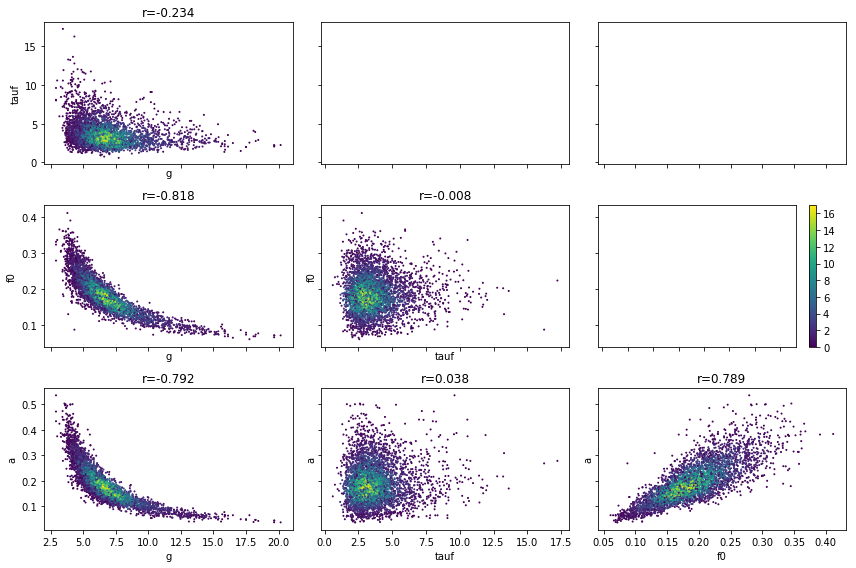

In [99]:
from matplotlib.colors import Normalize

fig, axs = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(12, 8))
S = np.array([mcmc.trace('g')[:], mcmc.trace('tauf')[:], mcmc.trace('f0')[:], mcmc.trace('a')[:]])
K = stats.gaussian_kde(S)
p = K(S)
cmap = plt.cm.viridis
norm = Normalize(vmin=0, vmax=np.ceil(p.max()))
for p1, p2 in combinations(['g', 'tauf', 'f0', 'a'], 2):
    d2 = 0 if p1 == 'g' else 1 if p1=='tauf' else 2
    d1 = 0 if p2 =='tauf' else 1 if p2=='f0' else 2
    plt.sca(axs[d1,d2])
    plt.scatter(mcmc.trace(p1)[:], mcmc.trace(p2)[:], s=1, color=cmap(norm(p)))
    plt.xlabel(p1)
    plt.ylabel(p2)
    plt.title('r=%.3f'%(np.corrcoef(mcmc.trace(p1)[:], mcmc.trace(p2)[:])[0, 1]))

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.sca(axs[1, 2])
plt.colorbar(sm)
fig.tight_layout()

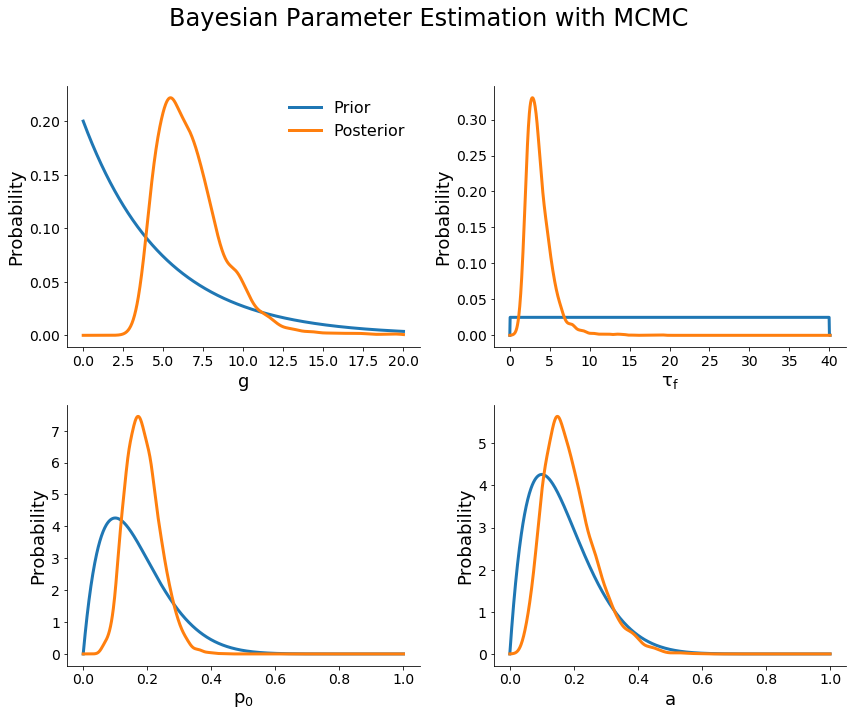

In [4]:
'''Plot prior and posterior distributions'''

'''Ranges to plot distribution over'''
x1 = np.linspace(0,20,1000)
x2 = np.linspace(0,40.1,1000)
x3 = np.linspace(0,1,1000)

'''Prior distributions'''
g_prior = stats.expon.pdf(x1,scale=5.)
tauf_prior = stats.uniform.pdf(x2,0.01,40)
f0_prior = a_prior = stats.beta.pdf(x3,2,10)

x = [x1,x2,x3,x3]
parnames = ['g',r'$\mathrm{\tau_f}$','$\mathrm{p_0}$','a']
priors = [g_prior,tauf_prior,f0_prior,a_prior]

'''Plot prior distributions'''
fig = plt.figure(figsize=(12,9))
for prior,string,xx,i in zip(priors,parnames,x,range(4)):
    plt.subplot(2,2,i+1)
    plt.plot(xx,prior,lw=3)
    plt.xlabel(string,fontsize=18)
    plt.ylabel('Probability',fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    remove_upper_right_ticks(plt.gca())

'''Plot kernel density estimates of posterior distributions from posterior samples'''
for mname,xx,pname,i in zip(['g','tauf','f0','a'],x,parnames,range(4)):
    samp=mcmc.trace(mname)[:]
    kde = stats.gaussian_kde(samp)
    plt.subplot(2,2,i+1)
    plt.plot(xx,kde(xx),lw=3)

plt.subplot(221)
plt.legend(['Prior','Posterior'],frameon=False,fontsize=16)
fig.tight_layout()
fig.suptitle('Bayesian Parameter Estimation with MCMC',fontsize=24,y=1.1)

In [3]:
def weight_criterion(crit):
    '''Compute AIC/BIC weights Wagenmakers et al (2004)'''
    d = np.exp(-0.5*(crit - np.min(crit,axis=0)).mean(axis=1)) # exponential of average difference with min. value
    w = d.T/np.sum(d) # normalised into probability space
    return w

with open('./fig3_data/AIC_epsc.csv','r') as myfile:
    AIC = np.loadtxt(myfile,delimiter=',')
    
with open('./fig3_data/BIC_epsc.csv','r') as myfile:
    BIC = np.loadtxt(myfile,delimiter=',')

wAIC = weight_criterion(AIC)
wBIC = weight_criterion(BIC)

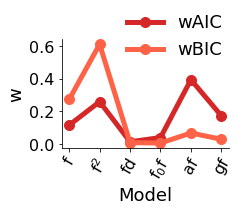

In [4]:
'''Plot Weight distribution'''

fig = plt.figure(figsize=(9,6))
plt.plot(wAIC,'-o',color='C3',lw=5,ms=10,label='wAIC')
plt.plot(wBIC,'-o',color='tomato',lw=5,ms=10,label='wBIC')
plt.xlabel('Model',fontsize=18)
plt.xticks(range(6),['f','f$^2$','fd','f$_0$f','af','gf'],rotation=60,fontsize=16);
yloc,ylab = plt.yticks()
plt.yticks(yloc[1::2],fontsize=16)
plt.ylabel('w',fontsize=18)

remove_upper_right_ticks(plt.gca())

plt.legend(bbox_to_anchor=(0., 0.8, 1., .5),
           borderaxespad=0.,
          fontsize=18,frameon=False)

fig.set_size_inches(3,2)
fig.savefig('./reworked_figs/mf-epsc-aicbic.svg')

In [10]:
wAIC[4]/wAIC[1],wBIC[1]/wBIC[4]

(1.5168092052663473, 8.9223669507496197)

In [21]:
with open('./fig3_data/AIC_ipsc.csv','r') as myfile:
    AIC = np.loadtxt(myfile,delimiter=',')[:-1]
    
with open('./fig3_data/BIC_ipsc.csv','r') as myfile:
    BIC = np.loadtxt(myfile,delimiter=',')[:-1]

In [22]:
wAIC = weight_criterion(AIC)
wBIC = weight_criterion(BIC)

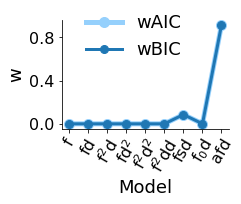

In [26]:
'''Plot weight distribution'''

fig = plt.figure(figsize=(9,6))
plt.plot(wAIC,'-o',color='xkcd:light blue',lw=5,ms=10,label='wAIC')
plt.plot(wBIC,'-o',color='C0',lw=3,ms=8,label='wBIC')
plt.xlabel('Model',fontsize=18)
plt.xticks(range(9),('f','fd','f$^2$d','fd$^2$','f$^2$d$^2$','f$^2$dd','fsd','f$_0$d','afd'),rotation=60,fontsize=16);
yloc,ylab = plt.yticks()
plt.yticks(yloc[1::2],fontsize=16)
plt.ylabel('w',fontsize=18)

remove_upper_right_ticks(plt.gca())

plt.legend(bbox_to_anchor=(0.1, 1.02, 1., .102),
           borderaxespad=0.,
          fontsize=18,frameon=False)

fig.set_size_inches(3,2)
fig.savefig('./reworked_figs/mf-ipsc-aicbic.svg')

## Load PSC amplitudes and posterior distributions for selected models

#### Data processing functions

In [28]:
'''
Irregular stimulation protocol data
'''

def load_amps_irr_csv(path):
    with open(path+'.csv','rb') as myfile:
        rd = csv.reader(myfile)
        data = [row for row in rd]
        amps = np.array([eval(d) for d in data[0]])
        ivls = np.squeeze([eval(l) for l in data[1]])
    return amps,ivls

def load_all_data(filedict):
    PRE = []
    PST = []
    path = filedict['path']
    for num in filedict['filenums']:
        [pre,pst],ivls=load_amps_irr_csv(path+str(num))
        PRE.append(pre);PST.append(pst);
    PRE = np.array(PRE); PST = np.array(PST)
    return PRE,PST,ivls

'''
Posterior Distributions
'''

def all_pop_dist(dists,n,X):
    npars = len(dists)/(n*2)
    pre_pop_dist = []
    pst_pop_dist = []
    for ii,xx in zip(xrange(npars),X):
        par_dist = dists[ii::npars]
        pre_par_dist = par_dist[::2]; pst_par_dist = par_dist[1::2]
        pre_pop_dist.append(pop_dist(pre_par_dist,xx,n=5000))
        pst_pop_dist.append(pop_dist(pst_par_dist,xx,n=5000))
        
    pre_pop_dist = np.array(pre_pop_dist)
    pst_pop_dist = np.array(pst_pop_dist)
    return pre_pop_dist,pst_pop_dist
    
        
'''Inverse Sampling from an arbitrary distribution'''
def inv_sampling(p,x,n=1,seed=None):
    np.random.seed(seed)
    inv_cdf = interp1d(np.cumsum(p-np.min(p))/np.sum(p-np.min(p)),x,bounds_error=False)
    d = np.array([])
    while len(d)<n:
        d_new = inv_cdf(np.random.random(n-len(d)))
        d = np.append(d,d_new[~np.isnan(d_new)])
    return d

'''Average distribution'''
def pop_dist(dists,x,n=1000):
    s = []
    for d in dists:
        s.append(inv_sampling(d,x,n))
    s = np.ravel(s)
    k = stats.gaussian_kde(s)
    return k(x)

####  Load

In [29]:
'''Dictionary for loading data'''
ifiledict = {'path':'./fig3_data/cch_ipsc','filenums':[1,2,3,4,5]}
efiledict = {'path':'./fig3_data/cch_epsc','filenums':[1,4,5,6,8,9]}
    
cch_pre_amps_ipsc,cch_pst_amps_ipsc,ivls = load_all_data(ifiledict)
cch_pre_amps_epsc,cch_pst_amps_epsc,ivls = load_all_data(efiledict)

'''Load posterior distributions'''

with open('./fig3_data/afd_cch_kde.csv','rb') as myfile:
    rd = csv.reader(myfile,delimiter=',')
    idists = [row for row in rd]
    idists = [map(np.float,d) for d in idists]

with open('./fig3_data/fac2_cch_kde.csv','rb') as myfile:
    rd = csv.reader(myfile,delimiter=',')
    edists = [row for row in rd]
    edists = [map(np.float,d) for d in edists]

'''Average Posterior distributions'''
    
Xe = [np.linspace(0,20,1000),
      np.linspace(0,40,1000),
      np.linspace(0,1,1000),
      np.linspace(0,1,1000)]
    
cch_pre_pop_epsc,cch_pst_pop_epsc = all_pop_dist(edists,n=len(efiledict['filenums']),X=Xe)

Xi = [np.linspace(0,100,1000),
      np.linspace(0,5,1000),
      np.linspace(0,5,1000),
      np.linspace(0,25,1000),
      np.linspace(0,1,1000),
      np.linspace(0,1,1000),
      np.linspace(0,1,1000)]

cch_pre_pop_ipsc,cch_pst_pop_ipsc = all_pop_dist(idists,n=len(ifiledict['filenums']),X=Xi)

## Posterior distribution Goodness-of-fit 

#### Analysis functions

In [30]:
'''IPSC Short Term Plasticity Model'''

def afd(pars,ivls_list=[ivls]):
    g,taup,taud,taua,p0,a0,b = pars
    # initialise
    amps = []
    for ivls in ivls_list:
        p = p0
        a = a0
        q=1
        amps.append(g*p*q)
        for ivl in ivls:
            p_old,a_old,q_old = p,a,q
            qinc = q_old - p_old*q_old
            pinc = p_old+a_old*(1-p_old)
            ainc = a_old+b*(1-a_old)
            p_new = p0 - np.exp(-ivl/taup)*(p0-pinc)
            a_new = a0 - np.exp(-ivl/taua)*(a0-ainc)
            q_new = 1 - (1-qinc)*np.exp(-ivl/taud)
            p,a,q = p_new,a_new,q_new
            amps.append(g*p*q)
    return np.array(amps)

'''EPSC Short term plasticity model'''

def fac2(pars,ivls_list=[ivls]):
    g,taup,p0,a = pars
    amps=[]
    for ivls in ivls_list:
        p = p0
        amps.append(g*p**2)
        for ivl in ivls:
            p_old = p
            pinc = p_old + a*(1-p_old)
            p_new = p0 - (p0 -pinc)*np.exp(-ivl/taup)
            p = p_new
            amps.append(g*p**2)
    return np.array(amps)

''' Distribution Moments'''

def dist_moments(p,x):
    mu = np.sum(p*x*np.diff(x)[0])
    vr = np.sum((x-mu)**2*p*np.diff(x)[0])
    return mu,vr

''' Simulated Data from Posterior Samples'''

def sim_amps(pop_dists,ivls,mdl,n,X):
    x_sim = []
    for i in xrange(n):
        s_pars = [inv_sampling(pd,xx) for pd,xx in zip(pop_dists,X)]  
        mu_amps = mdl(s_pars,[ivls])
        std_amps = 0.5*mu_amps
        x_sim.append(np.random.randn(len(mu_amps),1)*std_amps + mu_amps)
    return np.squeeze(x_sim)

''' Expected Data from Posterior Distribution'''

def ev_amps(pop_dists,ivls,mdl,X):
    e_pars  = [dist_moments(pd,xx)[0] for pd,xx in zip(pop_dists,X)]
    x_ev = mdl(e_pars,[ivls])
    return x_ev

''' Freeman-Tukey Discepancy Statistic'''
def freeman_tukey(x,e):
    d = np.sum((np.sqrt(np.clip(x,0,np.inf)) - np.sqrt(e))**2,axis=0)/len(x)
    return d

'''Bayesian Posterior predictive p-value'''
def bpp_pval(x_sim,x_ev,x_obs):
    d_sim = freeman_tukey(x_sim,x_ev)
    d_obs = freeman_tukey(x_obs,x_ev)
    p = np.mean(d_sim>d_obs)
    return p,d_sim,d_obs

#### Plotting functions 

In [14]:
'''Plot'''

def plot_gof(pre_amps,pst_amps,pre_pop,pst_pop,ivls,mdl,X,color,figsize=(12,2)):
    
    fig,axs = plt.subplots(nrows=1,ncols=2,figsize=figsize,sharex=True,sharey=True)
    
    for amps,theta,ax in zip([pre_amps,pst_amps],
                             [pre_pop,pst_pop],
                             axs):
    
        x_ev = ev_amps(theta,ivls,mdl=mdl,X=X) # Expected values
        x_obs = amps # Observed Data

        plt.sca(ax)
        l_obs = plt.plot(x_obs.T,'-',color=color,lw=1)[0]; # Plot observed
        l_ev = plt.plot(x_ev.T,'-o',color='black',lw=2,ms=5,alpha=0.5)[0] # Plot expected

        x_sim = sim_amps(theta,ivls,mdl=mdl,X=X,n=1000) # Simulated data from posterior predictive
        bp,d_sim,d_obs = bpp_pval(x_sim,x_ev,x_obs) # Compute Bayes. post. pred. p-val.
        plt.text(0.8,1.0,'p=%.2f'%bp,transform=ax.transAxes,fontsize=14) # Insert p-val on figure

        remove_upper_right_ticks(ax)

        plt.xticks(fontsize=14,rotation=60)
        plt.yticks(fontsize=14)
    
    # Label axes, legends, prettify
    
    plt.legend([l_obs,l_ev],['Observed Data','Expected Values'],
               bbox_to_anchor=(0.65,1.25),fontsize=16,frameon=False)
    
    plt.sca(axs[0])
    plt.xlabel('Stimulus Number',fontsize=16)
    plt.ylabel('Amplitude (nS)',fontsize=16)
    
    axs[1].spines['left'].set_visible(False)
    axs[1].yaxis.set_ticks_position('none')
    
    fig.subplots_adjust(wspace=0.05)

    fig.suptitle('Goodness-of-fit',fontsize=20,x=0.5,y=1.2)
    
    return fig

##  MF-EPSC Goodness of Fit

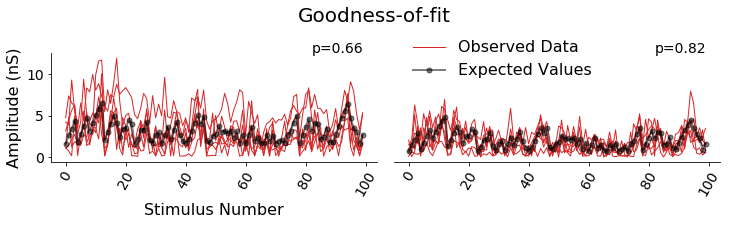

In [15]:
plot_gof(cch_pre_amps_epsc,cch_pst_amps_epsc,cch_pre_pop_epsc,cch_pst_pop_epsc,
         ivls,mdl=fac2,X=Xe,color='C3');

## MF-IPSC Goodness of Fit

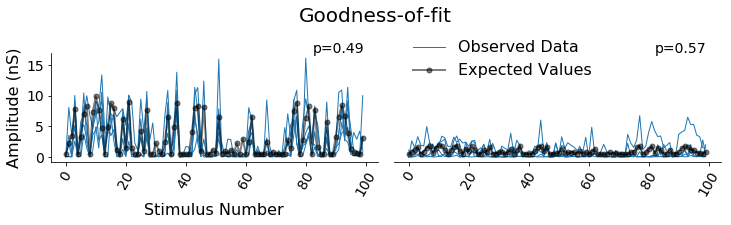

In [16]:
plot_gof(cch_pre_amps_ipsc,cch_pst_amps_ipsc,cch_pre_pop_ipsc,cch_pst_pop_ipsc,
         ivls,mdl=afd,X=Xi,color='C0');

## MF-EPSC CCh Change

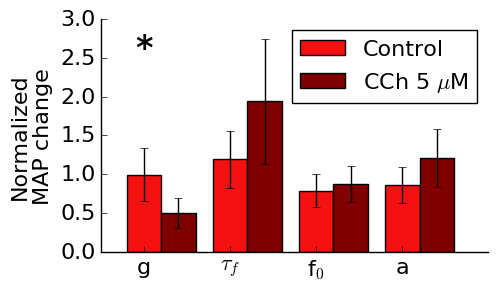

In [14]:
with open('./fig3_data/epsc_maps_norm.csv', 'rb') as myfile:
    epsc_maps_norm = np.loadtxt(myfile,delimiter=',',skiprows=1)

xpos = epsc_maps_norm.T[0]
epsc_maps_norm = epsc_maps_norm.T[1:]
fig = plt.figure(figsize=(5,3))
width = 0.4

for ix,maps in enumerate(epsc_maps_norm):
    b1 = plt.bar(ix-width/2,maps[xpos==0].mean(),yerr=maps[xpos==0].std(ddof=1),color='#F41111',ecolor='k',width=width)[0]
    b2 = plt.bar(ix+width/2,maps[xpos==1].mean(),yerr=maps[xpos==1].std(ddof=1),color='maroon',ecolor='k',width=width)[0]
    
plt.xticks(range(4),('g',r'$\tau_f$','f$_0$','a'),fontsize=16);
plt.yticks(fontsize=16)
plt.legend((b1,b2),('Control','CCh 5 $\mu$M'),fontsize=16)
plt.ylabel('Normalized\nMAP change',fontsize=16)

ax = plt.gca()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.text(0,2.5,'*',fontsize=24,fontdict={'weight':'bold','ha':'center'})

#fig.savefig('./reworked_figs/mf-epsc-cch-map.svg')

In [15]:
epsc_maps_norm[0][xpos==1].mean()
epsc_maps_norm[0][xpos==1].std()

0.17612493515994054

## MF-IPSC CCh Change

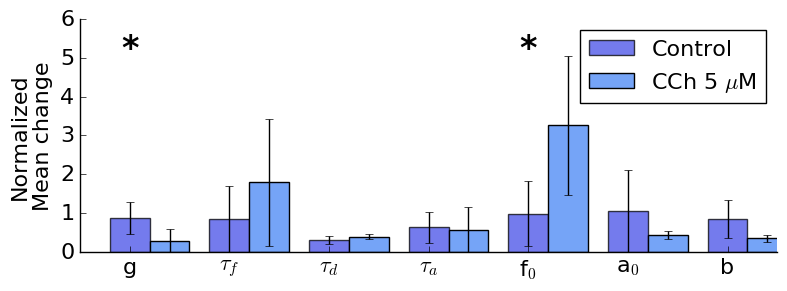

In [17]:
with open('./fig3_data/ipsc_maps_norm.csv', 'rb') as myfile:
    ipsc_maps_norm = np.loadtxt(myfile,delimiter=',',skiprows=1)

xpos = ipsc_maps_norm.T[0]
ipsc_maps_norm = ipsc_maps_norm.T[1:]
fig = plt.figure(figsize=(9,3))
width = 0.4

for ix,maps in enumerate(ipsc_maps_norm):
    b1 = plt.bar(ix-width/2,maps[xpos==0].mean(),yerr=maps[xpos==0].std(ddof=1),color='#454FE8',ecolor='k',width=width,alpha=0.75)[0]
    b2 = plt.bar(ix+width/2,maps[xpos==1].mean(),yerr=maps[xpos==1].std(ddof=1),color='#75A4F7',ecolor='k',width=width)[0]
    
plt.xticks(range(7),('g',r'$\tau_f$',r'$\tau_d$',r'$\tau_a$','f$_0$','a$_0$','b'),fontsize=16);
plt.yticks(fontsize=16)
plt.legend((b1,b2),('Control','CCh 5 $\mathrm{\mu}$M'),fontsize=16)
plt.ylabel('Normalized\nMean change',fontsize=16)
plt.ylim(0,6)
plt.xlim(-0.5,6.5)

ax = plt.gca()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.text(0,5,'*',fontsize=24,fontdict={'weight':'bold','ha':'center'})
plt.text(4,5,'*',fontsize=24,fontdict={'weight':'bold','ha':'center'})

#fig.savefig('./reworked_figs/mf-ipsc-cch-map.svg')

In [23]:
ipsc_maps_norm[4][xpos==1].mean()
ipsc_maps_norm[4][xpos==1].std()

1.6009542601510802

In [2]:
import csv

with open('./fig3_data/afd_cch_kde.csv','rb') as myfile:
    rd = csv.reader(myfile,delimiter=',')
    idists = [row for row in rd]
    idists = [map(np.float,d) for d in idists]

with open('./fig3_data/fac2_cch_kde.csv','rb') as myfile:
    rd = csv.reader(myfile,delimiter=',')
    edists = [row for row in rd]
    edists = [map(np.float,d) for d in edists]

Error: iterator should return strings, not bytes (did you open the file in text mode?)

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [25]:
idists = np.loadtxt('./fig3_data/afd_cch_kde.csv', delimiter=',')

In [26]:
Xi = [np.linspace(0,100,1000),
      np.linspace(0,5,1000),
      np.linspace(0,5,1000),
      np.linspace(0,25,1000),
      np.linspace(0,1,1000),
      np.linspace(0,1,1000),
      np.linspace(0,1,1000)]

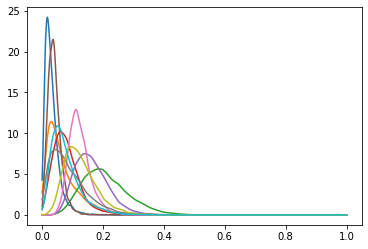

In [35]:
i = 6
plt.plot(Xi[i], idists[i::7].T)